In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score,confusion_matrix
from sklearn.model_selection import train_test_split
import copy
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import bokeh
import bokeh.plotting
from bokeh.layouts import column, row
from bokeh.models import HoverTool,WheelZoomTool, PanTool, ResetTool
bokeh.io.output_notebook()

Loading BokehJS ...

In [2]:
def plot_results(history):
    tools = [PanTool(), WheelZoomTool(), ResetTool(), HoverTool()]
    p = bokeh.plotting.figure(title='Training and validation loss', tools=tools)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    p.line(epochs, loss, color='blue', legend_label='Training loss')
    p.line(epochs, val_loss, color='red', legend_label='Validation loss')
    p.yaxis.axis_label = "Loss"
    p.xaxis.axis_label = 'Epochs'
    p.legend.click_policy="hide"
    p.legend.visible=False

    q = bokeh.plotting.figure(title='Training and validation accuracy', tools=tools)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    q.line(epochs, acc, color='blue', legend_label='training')
    q.line(epochs, val_acc, color='red', legend_label='validation')
    q.yaxis.axis_label = "Accuracy"
    q.xaxis.axis_label = 'Epochs'
    q.legend.click_policy="hide"
    q.legend.location="bottom_right"
    bokeh.io.show(row(p, q))

In [3]:
def standard_scalar_normalize(data_train, data_test): 
    scaler = StandardScaler()
    scaler.fit(data_train)
    normal_data_train = scaler.transform(data_train)
    normal_data_test = scaler.transform(data_test)
    return normal_data_train,normal_data_test

In [4]:
def data_processed():
    '''
    Used to read & normalize processed test and train data
    '''
    data_train=pd.read_csv("data/2022-02-07_LOANS_TRAIN.csv")
    data_test=pd.read_csv("data/2022-02-07_LOANS_TEST.csv")
    y_train=data_train['loan_status']
    data_train.drop(columns=['loan_status', 'id', 'issue_d_in_months', 'issue_d_year', 'zip_state_match', 
                               'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI',
                               'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN',
                               'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH',
                               'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA',
                               'WI', 'WV', 'WY'], inplace=True)
    
    data_test.drop(columns=['id', 'issue_d_in_months', 'issue_d_year', 'zip_state_match', 
                           'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI',
                           'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN',
                           'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH',
                           'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA',
                           'WI', 'WV', 'WY'], inplace=True)
    
    normal_data_train,normal_data_test=standard_scalar_normalize(data_train,data_test)
    return normal_data_train,normal_data_test,y_train

def AUC_score(y_ground_truth,y_predicted_probability):
    return roc_auc_score(y_ground_truth, y_predicted_probability)

In [91]:
X_train_full,X_test,Y_train_full=data_processed()
X_train, X_val, Y_train, Y_val = train_test_split(X_train_full, Y_train_full, train_size=0.80, random_state=42)

def over_under_sampling(X_train,Y_train,method,fraction):
    if method=="randomU":
        rus = RandomUnderSampler(random_state=0,sampling_strategy=fraction)
    elif method=="randomO":
        rus = RandomOverSampler(random_state=0,sampling_strategy=fraction)
    elif method=="centroid":
        rus = ClusterCentroids(random_state=42,sampling_strategy=fraction)
    elif method=="SMOTENN":
        rus = SMOTEENN(random_state=42,sampling_strategy=fraction)
    X_resampled, y_resampled = rus.fit_resample(X_train, Y_train)
    return X_resampled, y_resampled

X_train, Y_train = over_under_sampling(X_train,Y_train,"randomO",0.95)




## Gradient Boosting Classifier

In [102]:
gb_clf = GradientBoostingClassifier(max_depth=3, n_estimators=250, random_state=0)
gb_clf.fit(X_train, Y_train)
Y_train_pred_gb=gb_clf.predict(X_train)
Y_val_pred_gb=gb_clf.predict(X_val)
Y_val_pred_prob_gb=gb_clf.predict_proba(X_val)[:,1]
roc_auc_score(Y_val,Y_val_pred_prob_gb)

0.692454435092807

In [103]:
Y_train_pred_prob_gb=gb_clf.predict_proba(X_train)[:,1]


In [104]:
confusion_matrix(Y_val,Y_val_pred_gb)

array([[21758, 11590],
       [ 2275,  3827]])

In [105]:
np.std(Y_val_pred_prob_gb)

0.1664572763731593

## LGBM Classifier

In [92]:
lgbm_clf = LGBMClassifier(class_weight='balanced', max_depth=11, min_child_samples=60, n_estimators=80)
lgbm_clf.fit(X_train, Y_train)
Y_train_pred_lgbm=lgbm_clf.predict(X_train)
Y_val_pred_lgbm=lgbm_clf.predict(X_val)
Y_val_pred_prob_lgbm=lgbm_clf.predict_proba(X_val)[:,1]
roc_auc_score(Y_val,Y_val_pred_prob_lgbm)

0.6915276501544827

In [93]:
Y_train_pred_prob_lgbm=lgbm_clf.predict_proba(X_train)[:,1]


In [94]:
confusion_matrix(Y_val,Y_val_pred_lgbm)

array([[20915, 12433],
       [ 2147,  3955]])

In [95]:
np.std(Y_val_pred_prob_lgbm)

0.1688596771713375

In [140]:
lgbm_clf2 = LGBMClassifier(class_weight='balanced', max_depth=5, min_child_samples=75, n_estimators=120)
lgbm_clf2.fit(X_train, Y_train)
Y_train_pred_lgbm2=lgbm_clf2.predict(X_train)
Y_val_pred_lgbm2=lgbm_clf2.predict(X_val)
Y_val_pred_prob_lgbm2=lgbm_clf2.predict_proba(X_val)[:,1]
roc_auc_score(Y_val,Y_val_pred_prob_lgbm2)

0.6921475396449948

In [118]:
Y_train_pred_prob_lgbm2=lgbm_clf2.predict_proba(X_train)[:,1]


In [119]:
confusion_matrix(Y_val,Y_val_pred_lgbm2)

array([[21066, 12282],
       [ 2170,  3932]])

## Random Forest Classifier 

In [96]:
rf_clf = RandomForestClassifier(class_weight='balanced', max_depth=20, min_samples_leaf=25, n_estimators=400)
rf_clf.fit(X_train, Y_train)
Y_train_pred_rf=rf_clf.predict(X_train)
Y_val_pred_rf=rf_clf.predict(X_val)
Y_val_pred_prob_rf=rf_clf.predict_proba(X_val)[:,1]
roc_auc_score(Y_val,Y_val_pred_prob_rf)

0.6892415370668568

In [97]:
Y_train_pred_prob_rf=rf_clf.predict_proba(X_train)[:,1]


In [98]:
confusion_matrix(Y_val,Y_val_pred_rf)

array([[25459,  7889],
       [ 3136,  2966]])

In [99]:
np.std(Y_val_pred_prob_rf)

0.15069782558432085

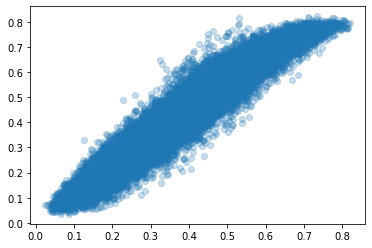

In [100]:
plt.scatter(Y_val_pred_prob_rf, Y_val_pred_prob_lgbm, alpha=0.25)


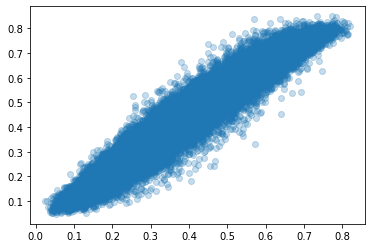

In [108]:
plt.scatter(Y_val_pred_prob_rf, Y_val_pred_prob_gb, alpha=0.25)


## Adaboost Classifier

In [14]:
ada_clf = AdaBoostClassifier(n_estimators=100)
ada_clf.fit(X_train, Y_train, sample_weight=copy.deepcopy(Y_train)*4 + 1)
Y_train_pred_ada=ada_clf.predict(X_train)
Y_val_pred_ada=ada_clf.predict(X_val)
Y_val_pred_prob_ada=ada_clf.predict_proba(X_val)[:,1]
roc_auc_score(Y_val,Y_val_pred_prob_ada)

0.6871605942746057

In [15]:
Y_train_pred_prob_ada=ada_clf.predict_proba(X_train)[:,1]


In [16]:
confusion_matrix(Y_val,Y_val_pred_ada)

array([[ 6426, 26922],
       [  318,  5784]])

In [17]:
np.std(Y_val_pred_prob_ada)

0.0019213296615988248

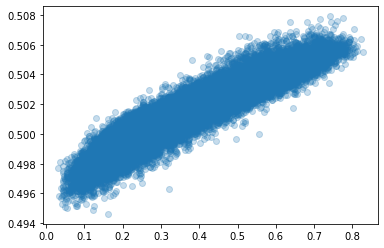

In [18]:
plt.scatter(Y_val_pred_prob_rf, Y_val_pred_prob_ada, alpha=0.25)

### Blend into an ensemble 
NN doesn't work very well.. hmmm

In [122]:
class LoanDataset(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
    def __len__(self):
        return len(self.Y)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [123]:
X_blend=np.concatenate((X_train, 
                        Y_train_pred_prob_lgbm.reshape(-1, 1), 
                        Y_train_pred_prob_rf.reshape(-1, 1), 
                        Y_train_pred_prob_gb.reshape(-1, 1), 
                        Y_train_pred_prob_lgbm2.reshape(-1, 1)), axis=1)
X_blend_val=np.concatenate((X_val, 
                            Y_val_pred_prob_lgbm.reshape(-1, 1), 
                            Y_val_pred_prob_rf.reshape(-1, 1), 
                            Y_val_pred_prob_gb.reshape(-1, 1), 
                            Y_val_pred_prob_lgbm2.reshape(-1, 1)), axis=1)

train_dataset = LoanDataset(X_blend, Y_train.values)
val_dataset = LoanDataset(X_blend_val, Y_val.values)

In [124]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [125]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(X_blend.shape[1], 100),
    nn.LeakyReLU(),
    nn.Dropout(0.15),
    nn.Linear(100, 10),
    nn.LeakyReLU(),
    nn.Dropout(0.15),
    nn.Linear(10, 1),
    nn.Sigmoid(),
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True) 

In [126]:
# Some layers, such as Dropout, behave differently during training
model.train()

for epoch in range(10):
    loss_sum = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        
        # NN likes floats
        data = data.float()
        target = target.float()
        
        # Erase accumulated gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)
        output = torch.squeeze(output) # need target shape to match output, so squeeze 2nd dimension out

        # Calculate loss
        loss = loss_fn(output, target)

        # Backward pass
        loss.backward()

        loss_sum += loss.item()
        
        # Weight update
        optimizer.step()

    # Track loss each epoch
    print('Train Epoch: %d  Loss: %.4f' % (epoch + 1,  loss_sum / len(train_loader.dataset)))

Train Epoch: 1  Loss: 0.0044
Train Epoch: 2  Loss: 0.0019
Train Epoch: 3  Loss: 0.0017
Train Epoch: 4  Loss: 0.0016
Train Epoch: 5  Loss: 0.0015
Train Epoch: 6  Loss: 0.0015
Train Epoch: 7  Loss: 0.0015
Train Epoch: 8  Loss: 0.0014
Train Epoch: 9  Loss: 0.0014
Train Epoch: 10  Loss: 0.0014


In [127]:
# Putting layers like Dropout into evaluation mode
model.eval()

val_loss = 0
correct = 0
pred_probs = []
targets = []
preds = []

# Turning off automatic differentiation
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(val_loader):
        data = data.to(device)
        target = target.to(device)
                
        data = data.float()
        target = target.float()
        
        output = model(data)
        output = torch.squeeze(output)
        
        val_loss += loss_fn(output, target).item()  # Sum up batch loss
        
        threshold = torch.tensor([0.5])
        pred = (output>threshold).float()*1
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        preds.extend(pred)
        targets.extend(target)
        pred_probs.extend(output)

val_loss /= len(val_loader.dataset)

print('Test set: Average loss: %.4f, Accuracy: %d/%d (%.4f)' %
      (val_loss, correct, len(val_loader.dataset),
       100. * correct / len(val_loader.dataset)))

print("ROC AUC score: ", roc_auc_score(targets, pred_probs))

Test set: Average loss: 0.0278, Accuracy: 31198/39450 (79.0824)
ROC AUC score:  0.6295907111588699


In [128]:
confusion_matrix(targets,preds)

array([[29981,  3367],
       [ 4885,  1217]])

## not quite sure why tensorflow's NN didn't really train?

probably something wonky with my installation since leaky_relu wasn't found for some reason...

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import activations

In [ ]:
network = models.Sequential()
network.add(layers.Dense(200, activation="relu", input_shape=(X_blend.shape[1],)))
network.add(layers.Dropout(0.15))
network.add(layers.Dense(110, activation="relu", input_shape=(X_blend.shape[1],)))
network.add(layers.Dropout(0.15))
network.add(layers.Dense(10, activation="relu"))
network.add(layers.Dense(1, activation="softmax"))
network.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

history = network.fit(X_blend, Y_train.values, batch_size=16, epochs=10, validation_split=0.2, shuffle=True, verbose=False)

test_loss, test_acc = network.evaluate(X_blend_val, Y_val.values)
print('the final accuracy on the holdout set was ', np.round(test_acc * 100, 2), '%')

y_pred_prob_nn = network.predict(X_blend_val)
y_pred_nn = network.predict(X_blend)
y_pred_nn[y_pred_nn>=0.5] = 1
y_pred_nn[y_pred_nn<0.5] = 0
y_val_pred_nn = network.predict(X_blend_val)
y_val_pred_nn[y_val_pred_nn>=0.5] = 1
y_val_pred_nn[y_val_pred_nn<0.5] = 0
print("ROC AUC score: ", roc_auc_score(Y_val.values, y_pred_prob_nn))

1233/1233 [==============================] - 1s 555us/step - loss: 0.0000e+00 - accuracy: 0.1547
the final accuracy on the holdout set was  15.47 %
ROC AUC score:  0.5


In [54]:
plot_results(history)

## Logistic Regression for ensembling
didn't work too well

In [ ]:
clf = LogisticRegression(random_state=0).fit(X_blend, Y_train)
Y_val_pred_prob=clf.predict_proba(X_blend_val)[:,1]
AUC_score(Y_val,Y_val_pred_prob)

## Use average voting
Works pretty well! 

In [129]:
Y_average = np.mean([Y_val_pred_prob_lgbm,Y_val_pred_prob_rf,Y_val_pred_prob_gb, Y_val_pred_prob_lgbm2], axis=0)

print(AUC_score(Y_val,Y_average))

Y_average[Y_average>=0.5] = 1
Y_average[Y_average<0.5] = 0
confusion_matrix(Y_val,Y_average)

0.6933912352901007


array([[22357, 10991],
       [ 2393,  3709]])

## Try classweights rather than oversampling
To test the difference from the above scores. Appears to do better if we use class weights instead. This is our best performing model. 

In [134]:
X_train_nosamp, X_val_nosamp, Y_train_nosamp, Y_val_nosamp = train_test_split(X_train_full, Y_train_full, train_size=0.80, random_state=42)

gb_clf_cw = GradientBoostingClassifier(max_depth=3, n_estimators=250, random_state=0)
gb_clf_cw.fit(X_train_nosamp, Y_train_nosamp, sample_weight=copy.deepcopy(Y_train_nosamp)*4 + 1)
Y_val_pred_prob_gb_cw=gb_clf_cw.predict_proba(X_val_nosamp)[:,1]


lgbm_clf_cw = LGBMClassifier(class_weight='balanced', max_depth=11, min_child_samples=60, n_estimators=80)
lgbm_clf_cw.fit(X_train_nosamp, Y_train_nosamp)
Y_val_pred_prob_lgbm_cw=lgbm_clf_cw.predict_proba(X_val_nosamp)[:,1]

lgbm_clf_cw2 = LGBMClassifier(class_weight='balanced', max_depth=5, min_child_samples=75, n_estimators=120)
lgbm_clf_cw2.fit(X_train_nosamp, Y_train_nosamp)
Y_val_pred_prob_lgbm_cw2=lgbm_clf_cw2.predict_proba(X_val_nosamp)[:,1]


rf_clf_cw = RandomForestClassifier(class_weight='balanced', max_depth=20, min_samples_leaf=25, n_estimators=400)
rf_clf_cw.fit(X_train_nosamp, Y_train_nosamp)
Y_val_pred_prob_rf_cw=rf_clf_cw.predict_proba(X_val_nosamp)[:,1]

val_probs = [Y_val_pred_prob_gb_cw,Y_val_pred_prob_lgbm_cw, Y_val_pred_prob_lgbm_cw2, Y_val_pred_prob_rf_cw]


In [135]:
Y_val_average = np.mean(val_probs, axis=0)
roc_auc_score(Y_val_nosamp,Y_val_average)

0.69412843796124

In [136]:
roc_auc_score(Y_val_nosamp,Y_val_pred_prob_gb_cw)

0.6936251441696037

In [137]:
roc_auc_score(Y_val_nosamp,Y_val_pred_prob_lgbm_cw)

0.6922932719829431

In [138]:
roc_auc_score(Y_val_nosamp,Y_val_pred_prob_lgbm_cw2)

0.6933680891322271

In [139]:
roc_auc_score(Y_val_nosamp,Y_val_pred_prob_rf_cw)

0.689694454793873

## Output to submission

In [131]:
gb_clf_full = GradientBoostingClassifier(max_depth=3, n_estimators=250, random_state=0)
gb_clf_full.fit(X_train_full, Y_train_full, sample_weight=copy.deepcopy(Y_train_full)*4 + 1)
Y_test_pred_prob_gb=gb_clf_full.predict_proba(X_test)[:,1]


lgbm_clf_full = LGBMClassifier(class_weight='balanced', max_depth=11, min_child_samples=60, n_estimators=80)
lgbm_clf_full.fit(X_train_full, Y_train_full)
Y_test_pred_prob_lgbm=lgbm_clf_full.predict_proba(X_test)[:,1]

lgbm_clf_full2 = LGBMClassifier(class_weight='balanced', max_depth=5, min_child_samples=75, n_estimators=120)
lgbm_clf_full2.fit(X_train_full, Y_train_full)
Y_test_pred_prob_lgbm2=lgbm_clf_full2.predict_proba(X_test)[:,1]


rf_clf_full = RandomForestClassifier(class_weight='balanced', max_depth=20, min_samples_leaf=25, n_estimators=400)
rf_clf_full.fit(X_train_full, Y_train_full)
Y_test_pred_prob_rf=rf_clf_full.predict_proba(X_test)[:,1]

test_probs = [Y_test_pred_prob_lgbm,Y_test_pred_prob_rf, Y_test_pred_prob_gb, Y_test_pred_prob_lgbm2]


In [143]:
def to_submission(ids, y_test_predicted_probability):
    y_test=pd.DataFrame(y_test_predicted_probability,columns=['loan_status'], index=ids)
    y_test.index.name = 'id'
    y_test.to_csv('data/submission.csv')
    return

Y_test_average = np.mean(test_probs, axis=0)
to_submission(pd.read_csv("data/2022-02-07_LOANS_TEST.csv")['id'].values, Y_test_average)